In [26]:
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import datetime

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [27]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

from torchvision import datasets, transforms
data_path = 'data/'


cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [28]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [29]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [30]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [31]:
augmentation_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
])

In [32]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, val_loader):
    loss_train_norm = np.zeros(n_epochs)
    loss_val_norm = np.zeros(n_epochs)
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        loss_val = 0.0
        for imgs, labels in train_loader:
            imgs = augmentation_transform(imgs)
            imgs = imgs.to(device=device)  # <1>
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        loss_train_norm[epoch-1] = loss_train / len(train_loader)

        for imgs, labels in val_loader:
            imgs = imgs.to(device=device)  # <1>
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            loss_val += loss.item()

        loss_val_norm[epoch-1] = loss_val / len(val_loader)

        if epoch == 1 or epoch % 10 == 0:
          print('{} Epoch {}, Training loss {}'.format(
              datetime.datetime.now(), epoch,
              loss_train_norm[epoch-1]))
          print('{} Epoch {}, Validation loss {}'.format(
              datetime.datetime.now(), epoch,
              loss_val_norm[epoch-1]))

    return loss_train_norm, loss_val_norm

In [33]:
def validate(model, train_loader, val_loader):
    accdict = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict

In [34]:
class WideResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x

        out = self.bn1(x)
        out = F.relu(out)
        out = self.conv1(out)

        out = self.bn2(out)
        out = F.relu(out)
        out = self.conv2(out)

        out += self.shortcut(residual)
        return out


class WideResNet(nn.Module):
    def __init__(self):
        super().__init__()

        num_blocks = 28
        k = 2
        num_classes = 2

        n = (num_blocks - 4) // 6

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)

        self.block1 = self._wide_block(WideResidualBlock, 16, 16*k, n, stride=1)
        self.block2 = self._wide_block(WideResidualBlock, 16*k, 32*k, n, stride=2)
        self.block3 = self._wide_block(WideResidualBlock, 32*k, 64*k, n, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(64*k, num_classes)

    def _wide_block(self, block, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(block(in_channels, out_channels, stride))

        for _ in range(1, num_blocks):
            layers.append(block(out_channels, out_channels, stride=1))

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)

        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)

        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)

        return out



In [35]:
model = WideResNet()  #  <2>
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')

loaded_model =  WideResNet().to(device=device)
loaded_model.load_state_dict(torch.load(data_path
                                        + 'birds_vs_airplanes.pt',
                                        map_location=device))

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=True)


model =  WideResNet().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

losstrain, lossval = training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
    val_loader = val_loader
)

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)
all_acc_dict = collections.OrderedDict()

all_acc_dict["baseline"] = validate(model, train_loader, val_loader)

print(sum(p.numel() for p in model.parameters()))

2023-06-20 13:21:40.668178 Epoch 1, Training loss 0.47290045611417975
2023-06-20 13:21:40.668298 Epoch 1, Validation loss 0.6000658916309476
2023-06-20 13:22:33.368155 Epoch 10, Training loss 0.2814683656973444
2023-06-20 13:22:33.368275 Epoch 10, Validation loss 0.2976506822742522
2023-06-20 13:23:31.284022 Epoch 20, Training loss 0.20631820974266454
2023-06-20 13:23:31.284139 Epoch 20, Validation loss 0.26023258175700903
2023-06-20 13:24:29.451542 Epoch 30, Training loss 0.16030929505730132
2023-06-20 13:24:29.451689 Epoch 30, Validation loss 0.25103657017461956
2023-06-20 13:25:27.473536 Epoch 40, Training loss 0.13225249974590958
2023-06-20 13:25:27.473665 Epoch 40, Validation loss 0.20814455393701792
2023-06-20 13:26:25.525217 Epoch 50, Training loss 0.10133631053457784
2023-06-20 13:26:25.525355 Epoch 50, Validation loss 0.33234785753302276
2023-06-20 13:27:23.695477 Epoch 60, Training loss 0.08088255699451087
2023-06-20 13:27:23.695603 Epoch 60, Validation loss 0.168026319588534

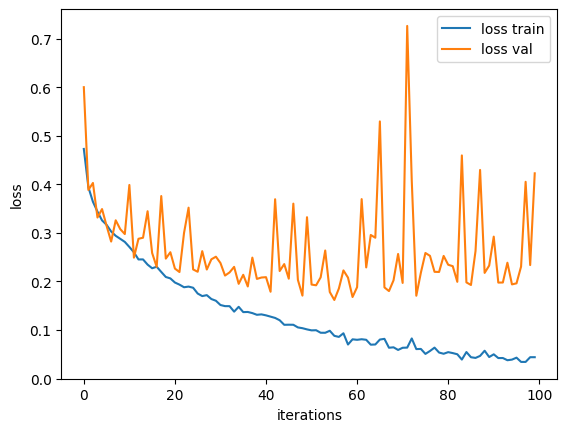

In [36]:
plt.plot(losstrain)
plt.plot(lossval)
plt.legend(['loss train', 'loss val'])
plt.xlabel('iterations')
plt.ylabel('loss')
plt.show()

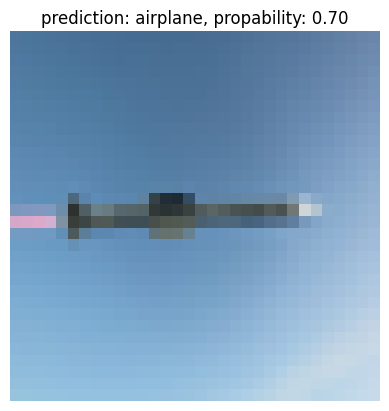

In [38]:
from PIL import Image

image = Image.open('data/Astra_MK-1_closeup.jpg')
image = image.resize((32, 32))
image = np.array(image)

tensor_image = torch.from_numpy(image)
tensor_image = tensor_image.permute(2, 0, 1).float()

output = model(tensor_image.to(device=device).unsqueeze(0))
output = F.softmax(output,dim=1)
confi, predicted = torch.max(output, dim=1)

plt.imshow(image)
plt.title(f"prediction: {class_names[predicted.item()]}, propability: {confi.item():.2f}")
plt.axis('off')
plt.show()

Im Gegensatz zu dem Netz davor, wird die LuftLuft Rakete nicht mehr mit einer hohen Wahrscheinlichkeit einem Flugzeug zugeordnet.

Das Netz aus dem Buch hat eine Validation Genauigkeit von 90%, die in etwa dem entspricht was mit diesem ResNet erreicht wird. Jedoch sieht man Übertraining, da der Validation Loss im Mittel nicht kleiner wird und sogar leicht ansteigt.